***Corso di Fondamenti e Applicazioni del Machine Learning - Progetto***

*A.A. 2024/25*

**Studenti:** *Davide Gualtieri, Aurora Giuliani, Samuele De Cesaris*

In questa prima parte di codice, vengono importate tutte le librerie per: analisi e manipolazione dei dati (pandas, numpy), visualizzazione (matplotlib, seaborn), machine learning e data preprocessing (scikit-learn), gestione warning (warnings). Successivamente viene configurato l'ambiente disattivando i warnings per evitare output confusi e impostando uno stile standardizzato per i grafici. Infine vengono introdotte funzioni che saranno richiamate all'interno del progetto per la pulizia dei dataset, che si occupano di: gestire il problema dei calciatori con più ruoli assegnati duplicandoli, in modo da trattare ogni ruolo come un'istanza separata, facilitando l'analisi del dataset; correggere la presenza di valori anomali o mancanti nelle colonne numeriche, sostituendoli con la media della colonna; pulire il dataset in maniera automatizzata. L'utilizzo delle funzioni è pensato per renderle riutilizzabili.

In [1]:
# Importazione librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Configurazione
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Funzione per sdoppiare i calciatori con ruoli multipli
def duplicate_players_by_roles(csv_file, roles_column='Ruolo?', separator=','):
    # Leggi il CSV
    df = pd.read_csv(csv_file, sep = ';')
    
    # Splitta la colonna dei ruoli in liste
    df[roles_column] = df[roles_column].str.split(separator)
    
    # Esplodi la colonna ruoli in più righe, duplicando le altre colonne
    df_expanded = df.explode(roles_column).reset_index(drop=True)
    
    # Salva il risultato in un nuovo CSV
    output_file = 'expanded_' + csv_file
    df_expanded.to_csv(output_file, index=False)
    
    print(f"File salvato come {output_file}")
    return df_expanded


# Funzione per sostituire da colonne numeriche valori anomali o Nan con la media della colonna
def impute_numeric_with_mean(df, cols=None):
    if cols is None:
        # Seleziona colonne numeric-like
        potential = df.select_dtypes(include=['number']).columns.tolist()
        object_cols = df.select_dtypes(include=['object']).columns
        for col in object_cols:
            converted = pd.to_numeric(df[col], errors='coerce')
            # Se almeno la metà dei valori è numerica, la consideriamo numeric-like
            if converted.notna().sum() >= len(converted) / 2:
                potential.append(col)
        cols = potential

    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mean_val = df[col].mean().round(0)  # calcola la media ignorando i NaN
        if not np.isnan(mean_val):
            df[col] = df[col].fillna(mean_val)
    return df

def limit_outliers(df):
    columns_rules = {
        'Reti': {'min': 0, 'max': 100},
        'Età': {'min': 15, 'max': 60},
        'Partite Giocate': {'min': 0, 'max': 100},
        'Minuti Giocati': {'min': 0, 'max': 10000},
        'Assist': {'min': 0, 'max': 100},
        'Reti Non Su Rigore': {'min': 0, 'max': 100},
        'Rigori Tirati': {'min': 0, 'max': 50},
        'Ammonizioni': {'min': 0, 'max': 50},
        'Espulsioni': {'min': 0, 'max': 15},
    }

    for col, rules in columns_rules.items():
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            mean_val = df[col].mean(skipna=True).round(0)

            # Limita i valori inferiori al minimo
            df[col] = df[col].apply(lambda x: rules['min'] if pd.notna(x) and x < rules['min'] else x)

            # Limita i valori superiori al massimo sostituendoli con la media
            df[col] = df[col].apply(lambda x: mean_val if pd.notna(x) and x > rules['max'] else x)

    return df



# Funzione per pulire il dataset
def clean_training_dataset(file_path, output_path='clean_set.csv'):

    # Leggi il CSV originale e fanne una copia
    df = pd.read_csv(file_path, sep=';')
    df_clean = df.copy()
    
    # Sdoppia i calciatoricon ruoli doppi
    df_clean= duplicate_players_by_roles(file_path)

    # Imputazione valori numerici con media
    df_clean = impute_numeric_with_mean(df_clean)

    # Gestione outlier 
    df_clean = limit_outliers(df_clean)

    # Salva il file pulito
    df_clean.to_csv(output_path, index=False)

    return df_clean

**TASK 1: Implementazione Manuale dei Classificatori**

In questa sezione vengono implementati manualmente i classificatori "Decision Tree" e "Gaussian Naive Bayes".
Per il Decision Tree, una volta effettuata l'inizializzazione e definiti i parametri, viene implementato il metodo fit, in cui le classi vengono convertite in valori numerici per facilitare i calcoli e viene effettuata la chiamata al metodo ricorsivo _grow_tree per costruire l'albero. Poi viene definita la funzione di crescita ricorsiva, attraverso l'approccio top-down tipico degli alberi decisionali, in cui vengono implementati il criterio di split (massimizzazione del guadagno informativo) e delle condizioni di terminazione ben definite per evitare overfitting. Seguono le funzioni per calcolare il miglior split, per l'entropia e per l'Information Gain. Alla fine troviamo le funzioni di predizione, che seguono un meccanismo di attraversamento ricorsivo dell'albero fino ai nodi foglia e di conversione inversa da valore numerico a label originale.
Per il Gaussian Naive Bayes manuale, invece, viene definito il metodo fit che calcola la media e la varianza per ogni classe; poi viene implementata una funzione di densità di probabilità, che utilizza la formula della distribuzione normale e l'assunzione Naive di indipendenza tra feature; infine effettua la predizione, tramite uso di logaritmi per evitare underflow numerico, prior uniforme semplificato e somma dei log-probabilità invece del prodotto.


In [2]:
# Implementazione manuale di Decision Tree
class ManualDecisionTree:
    """Implementazione manuale dell'algoritmo Decision Tree"""
    
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_names = None
    
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.feature_names = [f'feature_{i}' for i in range(self.n_features)]
        
        # Converte y in numerico se necessario
        self.classes_ = np.unique(y)
        self.class_to_num = {cls: i for i, cls in enumerate(self.classes_)}
        y_numeric = np.array([self.class_to_num[cls] for cls in y])
        
        self.tree = self._grow_tree(X, y_numeric)
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Condizioni di stop
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            n_classes == 1):
            most_common_class = Counter(y).most_common(1)[0][0]
            return {'value': most_common_class}
        
        # Trova il miglior split
        best_feat, best_thresh = self._best_split(X, y)
        if best_feat is None:
            most_common_class = Counter(y).most_common(1)[0][0]
            return {'value': most_common_class}
        
        # Crea split
        left_idx = X[:, best_feat] < best_thresh
        X_left, y_left = X[left_idx], y[left_idx]
        X_right, y_right = X[~left_idx], y[~left_idx]

        # Controllo per evitare split "vuoti"
        if len(y_left) == 0 or len(y_right) == 0:
            most_common_class = Counter(y).most_common(1)[0][0]
            return {'value': most_common_class}
        
        # Ricorsione per creare sottoalberi
        left = self._grow_tree(X_left, y_left, depth+1)
        right = self._grow_tree(X_right, y_right, depth+1)
        
        return {
            'feature': best_feat,
            'threshold': best_thresh,
            'left': left,
            'right': right
        }
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feat, best_thresh = None, None
        
        for feat_idx in range(self.n_features):
            thresholds = np.unique(X[:, feat_idx])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feat_idx, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = threshold
        return best_feat, best_thresh
    
    def _information_gain(self, X, y, feat_idx, threshold):
        parent_entropy = self._entropy(y)
        
        left_idx = X[:, feat_idx] < threshold
        if len(y[left_idx]) == 0 or len(y[~left_idx]) == 0:
            return 0
        
        n = len(y)
        n_left, n_right = len(y[left_idx]), len(y[~left_idx])
        e_left = self._entropy(y[left_idx])
        e_right = self._entropy(y[~left_idx])
        
        child_entropy = (n_left/n)*e_left + (n_right/n)*e_right
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        counts = counts[counts > 0]  # Rimuove gli zeri
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        # Converte da numerico a classe originale
        return np.array([self.classes_[pred] for pred in predictions])
    
    def _predict_single(self, x):
        node = self.tree
        while 'feature' in node:
            if x[node['feature']] < node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

# Implementazione manuale di Naive Bayes
class ManualNaiveBayes:
    """Implementazione manuale di Naive Bayes Gaussiano"""
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9  # evita divisione per zero
            }
    
    def _pdf(self, X, mean, var):
        return np.exp(-(X - mean)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)
    
    def predict(self, X):
        posteriors = []
        for x in X:
            class_probs = []
            for c in self.classes:
                prior = np.log(1.0 / len(self.classes))  # Assume prior uniforme
                likelihood = np.sum(np.log(self._pdf(x, self.parameters[c]['mean'], self.parameters[c]['var'])))
                class_probs.append(prior + likelihood)
            posteriors.append(self.classes[np.argmax(class_probs)])
        return np.array(posteriors)

**TASK 1: Caricamento e Valutazione sul Dataset Manuale**

Viene effettuato il caricamento e un anteprima del dataset, in modo tale da verificare che effettivamente il caricamento sia avvenuto correttamente e controllare la struttura dei dati.
Vengono estratte le feature e la variabile target, così da selezionare le colonne numeriche rilevanti come feature di input (X_manuale) e la variabile target (y_manuale); in modo da separare ciò che il modello deve apprendere (feature) da ciò che deve predire (target).
Viene fatta una normalizzazione delle feature, fondamentale per algoritmi come Naive Bayes che assumono distribuzioni gaussiane, e per evitare che feature con scale diverse influenzino eccessivamente il modello. Si utilizza StandardScaler per portare tutte le feature a media 0 e deviazione standard 1.
Viene poi fatta l'esplorazione del dataset, per assicurarsi che i dati siano corretti e bilanciati come rapida verifica prima del training.
Successivamente viene implementata la Leave-One-Out Cross Validation che prevede di usare ogni singolo elemento come test set e il resto come training set, garantendo che ogni dato venga testato.
Dopo c'è la fase di training e valutazione del Decision Tree manuale, addestrato appunto tramite la Cross-Validation LOO, dove si raccolgono le predizioni e si calcola l'accuracy media, che rappresenta la percentuale di classificazioni corrette. Questo approccio permette una valutazione robusta delle performance del modello su ogni esempio del dataset.
Poi c'è sempre la fase di training e di valutazione, ma stavolta dell'algoritmo Naive Bayes, dove si ripete la stessa procedura, ma usando feature normalizzate, elemento fondamentale per un modello gaussiano. 
Si confrontano quindi le accuracy dei due modelli per determinare quale sia il migliore sul dataset.
Infine vengono visualizzate le matrici di confusione dei due modelli, che evidenziano eventuali errori sistematici o confusioni tra classi simili. L'uso di heatmap rende la valutazione visiva immediata e intuitiva.
Viene poi stampato un report di classificazione dettagliato che fornisce metriche dettagliate come precision, recall e f1-score per ogni classe, offrendo una panoramica completa delle prestazioni dei modelli. Queste metriche sono fondamentali per capire non solo l'accuracy globale, ma anche la qualità della classificazione su ogni classe.

Anteprima dataset manuale:
  Stagione             Calciatore Squadra  Età  Partite Giocate  \
0  2024-25        Scott McTominay  Napoli   27               34   
1  2024-25  Alessandro Buongiorno  Napoli   25               22   
2  2024-25       Hakan Çalhanoğlu   Inter   30               29   
3  2024-25           Armando Izzo   Monza   32               30   
4  2024-25             Alex Meret  Napoli   27               34   

   Minuti Giocati  Reti  Assist  Reti Non Su Rigore  Rigori Tirati  \
0           2.938    12       4                  12             12   
1           1.924     1       0                   1              1   
2           1.947     5       6                   2              2   
3           2.435     1       1                   1              1   
4           3.005     0       0                   0              0   

   Ammonizioni  Espulsioni Ruolo?  
0            3           0    Cen  
1            2           0    Dif  
2            5           0    Cen  
3    

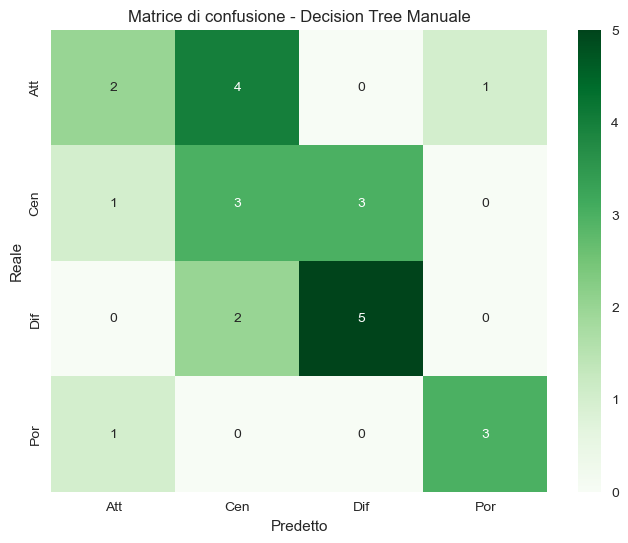

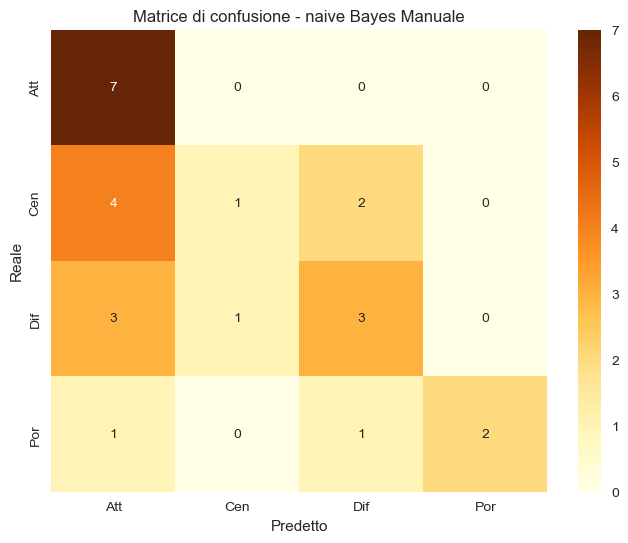

Data Decision Tree

              precision    recall  f1-score   support

         Att       0.50      0.29      0.36         7
         Cen       0.33      0.43      0.38         7
         Dif       0.62      0.71      0.67         7
         Por       0.75      0.75      0.75         4

    accuracy                           0.52        25
   macro avg       0.55      0.54      0.54        25
weighted avg       0.53      0.52      0.51        25

Data Naive Bayes

              precision    recall  f1-score   support

         Att       0.47      1.00      0.64         7
         Cen       0.50      0.14      0.22         7
         Dif       0.50      0.43      0.46         7
         Por       1.00      0.50      0.67         4

    accuracy                           0.52        25
   macro avg       0.62      0.52      0.50        25
weighted avg       0.57      0.52      0.48        25



In [3]:
# Caricamento dataset manuale
manuale_df = pd.read_csv('manuale.csv', sep=';')
print("Anteprima dataset manuale:")
print(manuale_df.head())

# Estrazione delle feature e della variabile target
feature_cols = ['Età', 'Partite Giocate', 'Minuti Giocati', 'Reti', 'Assist', 
                'Reti Non Su Rigore', 'Rigori Tirati', 'Ammonizioni', 'Espulsioni']
X_manuale = manuale_df[feature_cols].values
y_manuale = manuale_df['Ruolo?'].values

# Normalizzazione delle feature
scaler = StandardScaler()
X_manuale_scaled = scaler.fit_transform(X_manuale)

print(f"\nDimensioni dataset: {X_manuale.shape}")
print(f"Classi presenti: {np.unique(y_manuale)}")

# Configurazione Leave-One-Out Cross Validation
loo = LeaveOneOut()

# Test Decision Tree Manuale
dt_scores = []
dt_predictions = []
dt_true = []

for train_idx, test_idx in loo.split(X_manuale):
    X_train_loo, X_test_loo = X_manuale[train_idx], X_manuale[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]
    
    dt = ManualDecisionTree(max_depth=5, min_samples_split=2)
    dt.fit(X_train_loo, y_train_loo)
    pred = dt.predict(X_test_loo)
    
    dt_predictions.extend(pred)
    dt_true.extend(y_test_loo)
    dt_scores.append(pred[0] == y_test_loo[0])

dt_accuracy = np.mean(dt_scores)
print(f"\nDecision Tree Manuale - Accuracy: {dt_accuracy:.3f}")

# Test Naive Bayes Manuale
nb_scores = []
nb_predictions = []
nb_true = []

for train_idx, test_idx in loo.split(X_manuale_scaled):
    X_train_loo, X_test_loo = X_manuale_scaled[train_idx], X_manuale_scaled[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]
    
    nb = ManualNaiveBayes()
    nb.fit(X_train_loo, y_train_loo)
    pred = nb.predict(X_test_loo)
    
    nb_predictions.extend(pred)
    nb_true.extend(y_test_loo)
    nb_scores.append(pred[0] == y_test_loo[0])

nb_accuracy = np.mean(nb_scores)
print(f"Naive Bayes Manuale - Accuracy: {nb_accuracy:.3f}")

print(f"\nMigliore classificatore manuale: {'Naive Bayes' if nb_accuracy > dt_accuracy else 'Decision Tree'}")

# Visualizziamo la matrice di confusione per il Decision Tree
plt.figure(figsize=(8, 6))
cm = confusion_matrix(dt_true, dt_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - Decision Tree Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

# Visualizziamo la matrice di confusione per il naive Bayes
plt.figure(figsize=(8, 6))
cm = confusion_matrix(nb_true, nb_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - naive Bayes Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()
print('Data Decision Tree\n')
print(classification_report(dt_true, dt_predictions))
print('Data Naive Bayes\n')
print(classification_report(nb_true, nb_predictions))

**TASK 2: Caricamento e Pulizia del Dataset Training**

Viene caricato il dataset "training.csv" e pulito rimuovendo valori anomali tramite la funzione definita nella prima cella di codice.

In [4]:
training_df = pd.read_csv('training.csv', sep=';')
print(f"Dimensioni dataset originale: {training_df.shape}")
print("Anteprima dataset training:")
print(training_df.head())

# Applichiamo la funzione definita all'inizio
training_clean = clean_training_dataset('training.csv')


print(f"Dimensioni dataset pulito: {training_clean.shape}")

print("\nDataset pulito salvato come 'clean_set.csv'")

Dimensioni dataset originale: (2488, 13)
Anteprima dataset training:
  Stagione         Calciatore  Squadra   Età  Partite Giocate Minuti Giocati  \
0  2024-25     James Abankwah  Udinese  20.0              6.0             88   
1  2024-25    Saud Abdulhamid     Roma  25.0              4.0            205   
2  2024-25  Oliver Abildgaard     Como  28.0              1.0              7   
3  2024-25      Tammy Abraham     Roma  26.0              1.0              1   
4  2024-25      Tammy Abraham    Milan  26.0             28.0          1.183   

   Reti  Assist  Reti Non Su Rigore  Rigori Tirati  Ammonizioni Espulsioni  \
0   0.0     0.0                 0.0            0.0          1.0          0   
1   0.0     1.0                 0.0            0.0          0.0          0   
2   0.0     0.0                 0.0            0.0          0.0          0   
3   0.0     0.0                 0.0            0.0          0.0          0   
4   3.0     4.0                 2.0            2.0          

**TASK 2: Analisi Esplorativa con Visualizzazioni**

Vengono descritte le statistiche descrittive delle feature numeriche, selezionando solo le colonne (numeriche) rilevanti per l'analisi statistica. Il metodo describe() fornisce statistiche come media, deviazione standard, min e max, utili per individuare anomalie o valori fuori scala nella feature.
Poi vengono stampati vari grafici: il Boxplot delle feature numeriche che permette di visualizzare la distribuzione delle variabili numeriche, evidenziando outlier e mediana e aiuta a capire la dispersione dei dati e la presenza di valori anomali dopo la pulizia; la Matrice di Correlazione, che mostra le relazioni lineari tra le feature numeriche; il Pairplot delle feature principali per ruolo, che mostra le distribuzioni e le relazioni bivariate tra le principali feature, colorando i punti in base al ruolo (si limita il campione a 500 record per evitare sovraffollamento grafico); infine un Barplot che mostra la distribuzione dei ruoli, ovvero la frequenza di ciascun ruolo principale nel dataset pulito.


Statistiche descrittive:
           Età  Partite Giocate  Minuti Giocati     Reti   Assist  \
count  3036.00          3036.00         3036.00  3036.00  3036.00   
mean     25.32            18.98          180.52     1.70     1.21   
std       4.64            11.73          281.54     3.07     1.89   
min      15.00             1.00            1.00     0.00     0.00   
25%      22.00             8.00            1.91     0.00     0.00   
50%      25.00            20.00            3.26     0.00     0.00   
75%      28.00            30.00          274.00     2.00     2.00   
max      42.00            38.00          998.00    29.00    14.00   

       Reti Non Su Rigore  Rigori Tirati  Ammonizioni  Espulsioni  
count             3036.00        3036.00      3036.00     3036.00  
mean                 1.57           0.51         2.58        0.12  
std                  2.76           1.52         2.71        0.35  
min                  0.00           0.00         0.00        0.00  
25%         

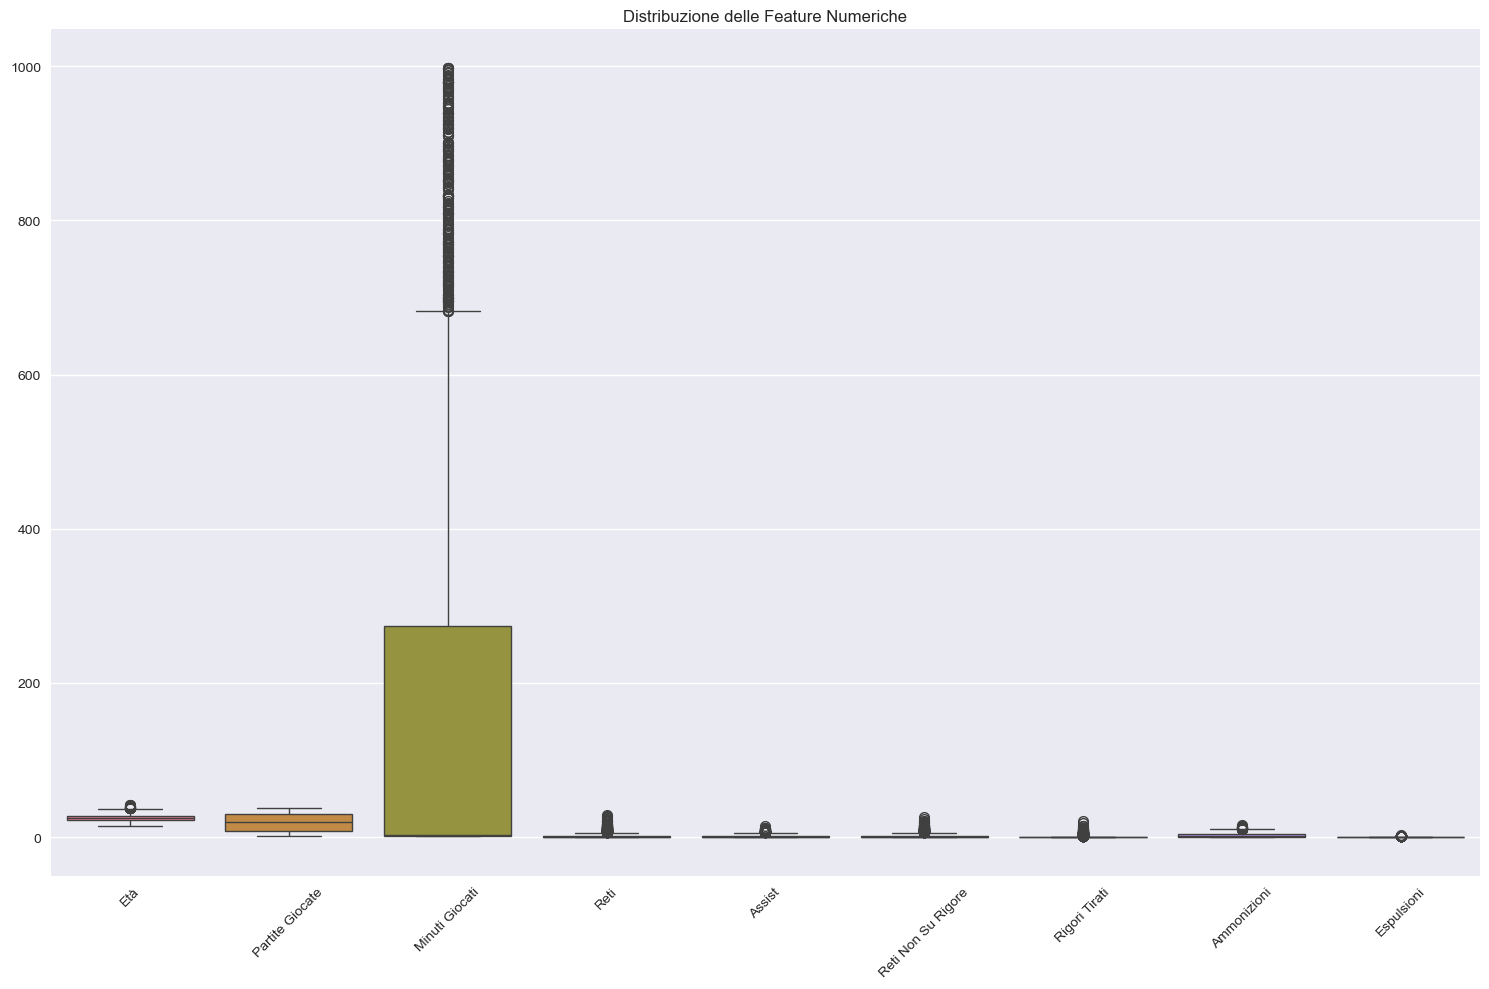

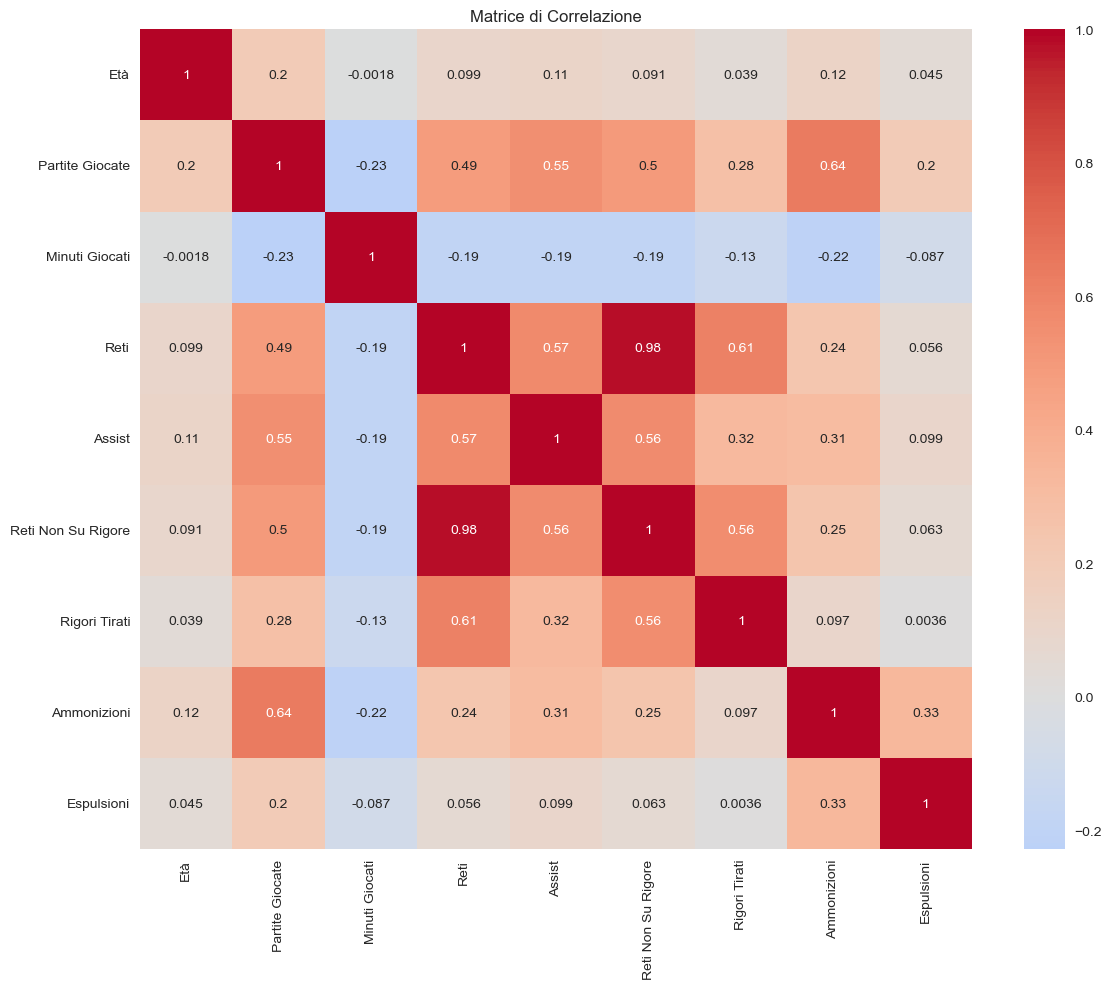

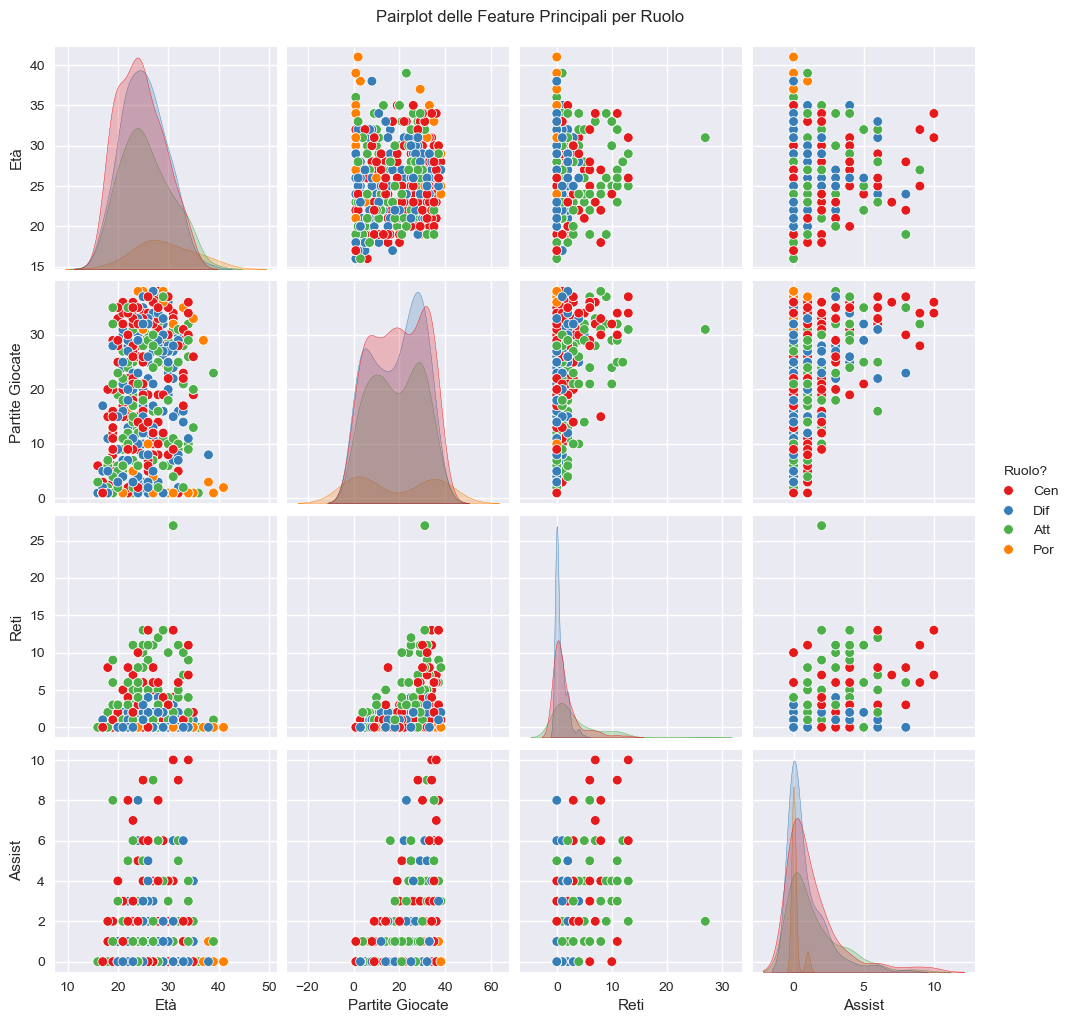

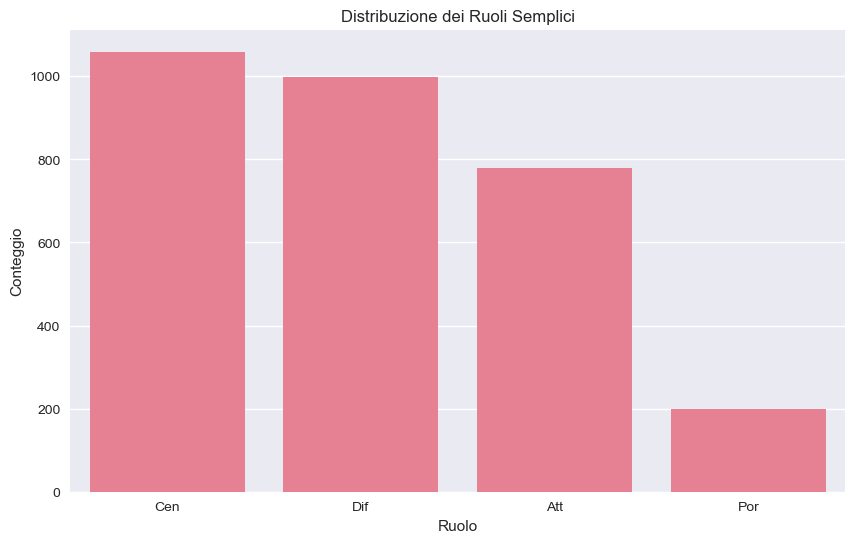

In [5]:
# Statistiche descrittive delle feature numeriche
distinct_palette = [
    "#E41A1C",  # Rosso
    "#377EB8",  # Blu
    "#4DAF4A",  # Verde
    "#FF7F00",  # Arancione
    "#984EA3",  # Viola
    "#FFFF33",  # Giallo
]

numeric_features = ['Età', 'Partite Giocate', 'Minuti Giocati', 'Reti', 'Assist', 
                   'Reti Non Su Rigore', 'Rigori Tirati', 'Ammonizioni', 'Espulsioni']

print("\nStatistiche descrittive:")
print(training_clean[numeric_features].describe().round(2))

# 1. Boxplot per feature numeriche
plt.figure(figsize=(15, 10))
sns.boxplot(data=training_clean[numeric_features])
plt.title('Distribuzione delle Feature Numeriche')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Matrice di correlazione
plt.figure(figsize=(12, 10))
corr_matrix = training_clean[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.tight_layout()
plt.show()

# 3. Pairplot per le feature principali con ruoli
# Prendiamo un campione più piccolo per rendere il grafico più leggibile
sample_size = 500
if len(training_clean) > sample_size:
    training_sample = training_clean.sample(sample_size, random_state=42)
else:
    training_sample = training_clean

# Filtra solo i ruoli semplici per il pairplot
simple_roles = ['Att', 'Cen', 'Dif', 'Por']
training_simple = training_sample[training_sample['Ruolo?'].isin(simple_roles)]

# Pairplot delle principali feature
main_cols = ['Età', 'Partite Giocate', 'Reti', 'Assist', 'Ruolo?']
sns.pairplot(training_simple[main_cols], hue='Ruolo?', palette=distinct_palette)
plt.suptitle('Pairplot delle Feature Principali per Ruolo', y=1.02)
plt.show()

# Visualizzazione della distribuzione dei ruoli
plt.figure(figsize=(10, 6))
role_counts_simple = training_clean[training_clean['Ruolo?'].isin(simple_roles)]['Ruolo?'].value_counts()
sns.barplot(x=role_counts_simple.index, y=role_counts_simple.values)
plt.title('Distribuzione dei Ruoli Semplici')
plt.xlabel('Ruolo')
plt.ylabel('Conteggio')
plt.show()

**TASK 3: Valutazione dei Classificatori Manuali sul Dataset Training**

Per prima cosa si scelgono le colonne numeriche rilevanti come input (X) e il ruolo come target (y), preparando i dati per l'addestramento dei modelli.
Poi si applica la normalizzazione tramite StandardScaler per portare tutte le feature su una scala comune (media 0, deviazione standard 1), fondamentale, come detto in precedenza, per modelli come Naive Bayes e utile per la stabilità numerica. In più si effettua lo split dei dati in training e test set (80/20), sia sui dati normalizzati che su quelli grezzi, mantenendo la proporzione delle classi (stratify=y) per garantire un confronto equo tra i modelli.
Dopo si passa alla fase di tuning degli iperparametri per il Decision Tree manuale con cross-validation, in cui si definiscono i parametri da testare, esplorando diverse profondità massime dell'albero e soglie minime di campioni per split per trovare la configurazione ottimale. Si utilizza StratifiedFold per valutare la robustezza di ogni combinazione di iperparametri, assicurando che ogni fold mantenga la distribuzione originale delle classi. Per ogni combinazione, si calcola l'accuracy media e si salva il risultato, facilitando il confronto tra diverse configurazioni.
Viene quindi effettuato il training sul Decision Tree manuale con i parametri selezionati e si valuta sulla partizione di test, riportando l'accuracy e il report di classificazione. Si utilizza ConfusionMatrixDisplay per rappresentare graficamente la matrice di confusione, rendendo immediata la comprensione degli errori di classificazione e delle classi più problematiche.
Poi si passa all'addestramento e alla valutazione dell'algoritmo Naive Bayes manuale: il modello viene addestrato e testato su dati standardizzati, poiché l'assunzione di gaussianità delle feature è più valida dopo la normalizzazione, e vengono calcolate accuracy e metriche di classificazione, oltre alla matrice di confusione per un confronto diretto con il Decision Tree.
Si fa infine un confronto visivo delle performance, creando un grafico a barre che confronta direttamente le accuracy dei due modelli manuali, che aiuta a capire quale modello si comporta meglio sul dataset.

Dataset con ruoli semplici: (3034, 13)
Train: (2427, 9), Test: (607, 9)
max_depth=3, min_split=2 --> acc=0.430
max_depth=3, min_split=3 --> acc=0.430
max_depth=3, min_split=5 --> acc=0.430
max_depth=5, min_split=2 --> acc=0.458
max_depth=5, min_split=3 --> acc=0.458
max_depth=5, min_split=5 --> acc=0.458
max_depth=10, min_split=2 --> acc=0.441
max_depth=10, min_split=3 --> acc=0.441
max_depth=10, min_split=5 --> acc=0.441

Decision Tree Manuale - Accuracy: 0.478
Report di classificazione Decision Tree Manuale:
              precision    recall  f1-score   support

         Att       0.58      0.37      0.45       156
         Cen       0.41      0.37      0.39       212
         Dif       0.47      0.69      0.55       200
         Por       0.77      0.44      0.56        39

    accuracy                           0.48       607
   macro avg       0.56      0.46      0.49       607
weighted avg       0.50      0.48      0.47       607



<Figure size 800x600 with 0 Axes>

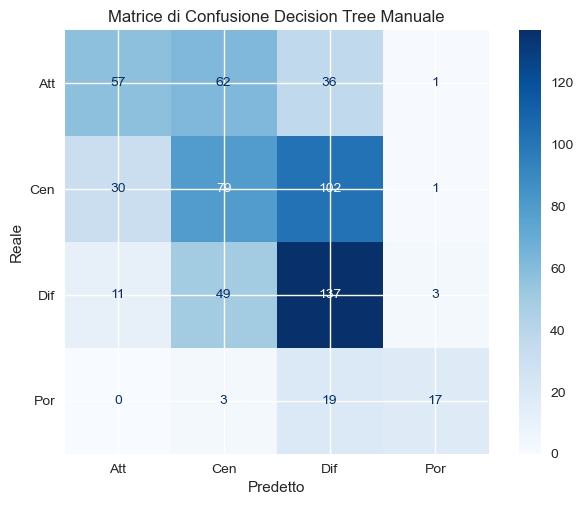


Naive Bayes Manuale - Accuracy: 0.297
Report di classificazione Naive Bayes Manuale:
              precision    recall  f1-score   support

         Att       0.54      0.24      0.34       156
         Cen       0.44      0.14      0.21       212
         Dif       0.41      0.36      0.38       200
         Por       0.13      1.00      0.24        39

    accuracy                           0.30       607
   macro avg       0.38      0.44      0.29       607
weighted avg       0.44      0.30      0.30       607



<Figure size 800x600 with 0 Axes>

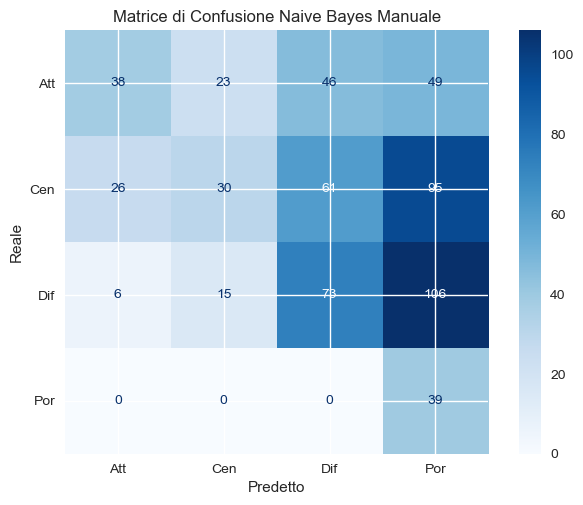

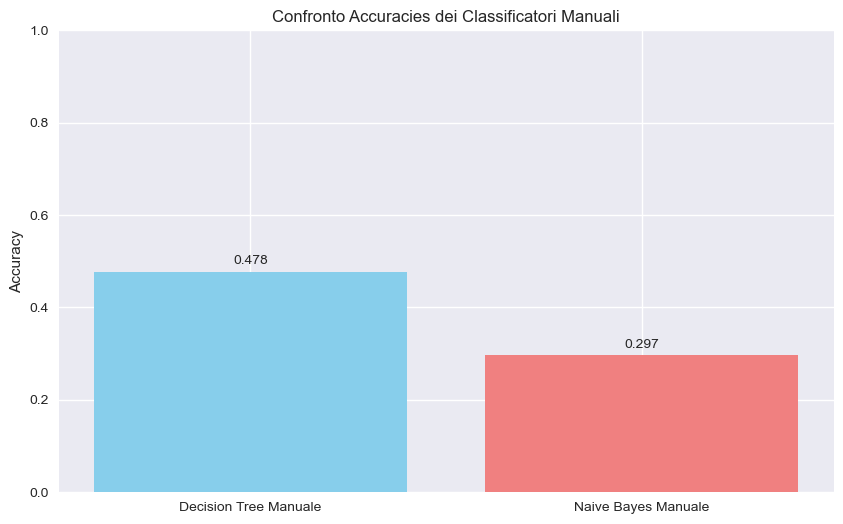

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


main_roles = ['Att', 'Cen', 'Dif', 'Por']
training_simple = training_clean[training_clean['Ruolo?'].isin(main_roles)].copy()

print(f"Dataset con ruoli semplici: {training_simple.shape}")

# Prepariamo i dati
feature_cols = ['Età', 'Partite Giocate', 'Minuti Giocati', 'Reti', 'Assist', 
                'Reti Non Su Rigore', 'Rigori Tirati', 'Ammonizioni', 'Espulsioni']

X = training_simple[feature_cols].values
y = training_simple['Ruolo?'].values

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_trainS, X_testS, y_trainS, y_testS = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Test Decision Tree manuale


# Parametri da testare
depths = [3, 5, 10]
min_splits = [2, 3, 5]

# Per salvare i risultati
results = []

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ciclo su tutte le combinazioni
for max_depth in depths:
    for min_split in min_splits:
        accuracies = []

        for train_idx, val_idx in cv.split(X_scaled, y):
            X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            # Inizializza il tuo albero manuale
            model = ManualDecisionTree(max_depth=max_depth, min_samples_split=min_split)
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_val_cv)

            acc = accuracy_score(y_val_cv, y_pred)
            accuracies.append(acc)

        mean_acc = np.mean(accuracies)
        results.append({
            'max_depth': max_depth,
            'min_samples_split': min_split,
            'mean_accuracy': mean_acc
        })
        print(f"max_depth={max_depth}, min_split={min_split} --> acc={mean_acc:.3f}")


dt = ManualDecisionTree(max_depth=5, min_samples_split=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"\nDecision Tree Manuale - Accuracy: {dt_acc:.3f}")
print("Report di classificazione Decision Tree Manuale:")
print(classification_report(y_test, dt_pred))

# Confusion matrix decision tree
cm = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Decision Tree Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


# Test Naive Bayes manuale
nb = ManualNaiveBayes()
nb.fit(X_trainS, y_trainS)
nb_pred = nb.predict(X_testS)
nb_acc = accuracy_score(y_testS, nb_pred)

print(f"\nNaive Bayes Manuale - Accuracy: {nb_acc:.3f}")
print("Report di classificazione Naive Bayes Manuale:")
print(classification_report(y_testS, nb_pred))

# Confusion matrix Bayes
cm_bayes = confusion_matrix(y_testS, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Naive Bayes Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# Confronto visivo delle performance
plt.figure(figsize=(10, 6))
labels = ['Decision Tree Manuale', 'Naive Bayes Manuale']
accuracies = [dt_acc, nb_acc]
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Confronto Accuracies dei Classificatori Manuali')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Aggiungiamo le etichette di accuracy sopra le barre
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.show()

**TASK 4: Modelli Scikit-Learn e Selezione del Migliore**

Si inizia impostando alcune variabili di supporto per tracciare i risultati e i migliori modelli trovati durante la ricerca degli iperparametri, che aiutano a gestire il processo di selezione del modello ottimale.
Viene poi definita una griglia di iperparametri per l'algoritmo, specificando diverse opzioni per il numero di alberi (n_estimators), la profondità massima (max_depth), il numero minimo di campioni per split e il metodo di selezione delle feature per ogni split (max_features). Ciò permette di esplorare diverse configurazioni e trovare quella che massimizza la performance del modello.
Dopo viene fatta la configurazione di GridSearchCV per eseguire una ricerca esaustiva su tutte le combinazioni degli iperparametri definiti. Il cross-validation a 5 fold (cv=5) garantisce una valutazione robusta delle prestazioni del modello riducendo il rischio di overfitting ai dati di training. (L'uso di n_jobs=1 sfrutta tutti i core disponibili per velocizzare il processo.)
Quindi viene eseguita la ricerca e l'analisi dei risultati: si addestra il modello su tutte le combinazioni di iperparametri e si stampa l'accuracy media ottenuta in cross-validation per ciascuna. Questo permette di confrontare facilmente le diverse configurazioni e identificare i parametri ottimali.
Vengono successivamente selezionati e stampati i parametri migliori (ovvero quelli che hanno portato alla migliore accuracy media in cross-validation).
Viene analizzata la learning curve, che mostra come variano le performance del modello all'aumentare della dimensione del training set e permette di diagnosticare problemi di underfitting o overfitting e di valutare se il modello potrebbe migliorare con più dati.
Dopo viene fatta una valutazione finale sul test set, utilizzando il miglior modello trovato per predire le etichette sul test set e si calcola l'accuracy finale, che rappresenta la capacità del modello di generalizzare su dati mai visti.
Infine viene fatto un report di classificazione che fornisce metriche dettagliate per ogni classe, offrendo una panoramica completa delle performance, e viene stampata una matrice di confusione che visualizza gli errori di classificazioni tra le classi, aiutando a identificare eventuali criticità specifiche.
Questo procedimento viene svolto per tutti i classificatori presi in esame: Random Forest, Logistic Regression, Decision Tree e Gaussian Naive Bayes.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50} -> Mean CV Accuracy: 0.4215
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100} -> Mean CV Accuracy: 0.4219
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200} -> Mean CV Accuracy: 0.4227
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50} -> Mean CV Accuracy: 0.4252
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100} -> Mean CV Accuracy: 0.4281
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200} -> Mean CV Accuracy: 0.4269
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50} -> Mean CV Accuracy: 0.4520
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100} -> Mean CV Accuracy: 0.4520
{'m

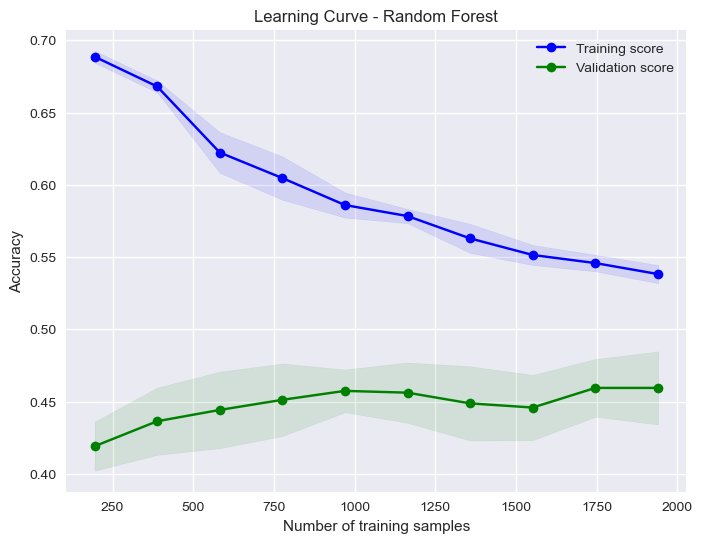


--- Classification Report ---
              precision    recall  f1-score   support

         Att       0.42      0.33      0.37       156
         Cen       0.37      0.40      0.38       212
         Dif       0.58      0.64      0.61       200
         Por       0.78      0.72      0.75        39

    accuracy                           0.48       607
   macro avg       0.54      0.52      0.53       607
weighted avg       0.48      0.48      0.48       607



<Figure size 800x600 with 0 Axes>

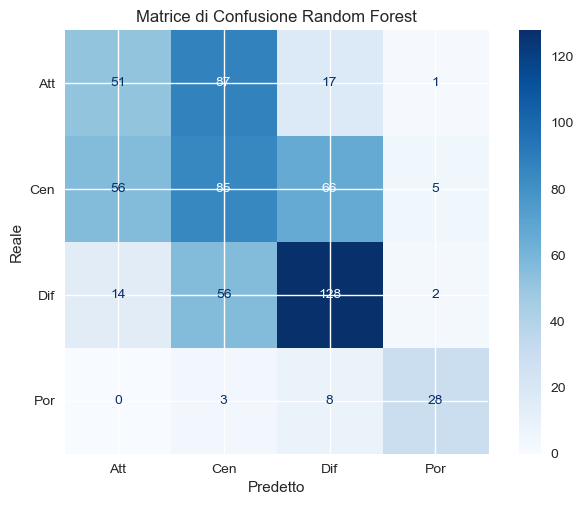

In [7]:
# ------------------------------- Random Forest----------------------------------

results = {}
best_acc = 0
best_model = None
best_name = None

# Definizione della griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Configurazione GridSearchCV
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione
grid_search.fit(X_train, y_train)

# Stampa dei risultati per ogni combinazione
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params} -> Mean CV Accuracy: {mean_score:.4f}")

# Stampa degli iperparametri migliori
random_forest_param = grid_search.best_params_
print("\nBest params:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")


# Learning curve
model = RandomForestClassifier(
    random_state=42,
    max_depth=5,
    max_features='sqrt',
    min_samples_split=10,
    n_estimators=50)

model_forest = grid_search.best_estimator_

accuracy_rf = grid_search.best_estimator_.score(X_test, y_test)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),  # Dimensioni del training set da 10% a 100%
    n_jobs=-1
)

# Calcolo media e deviazione standard per train e validation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='green')

plt.title('Learning Curve - Random Forest')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Validation 
y_pred = model_forest.predict(X_test)

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Random Forest")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga'} -> Mean CV Accuracy: 0.4079 (±0.0225)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'lbfgs'} -> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'} -> Mean CV Accuracy: 0.4483 (±0.0140)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'lbfgs'} -> Mean CV Accuracy: 0.4479 (±0.0132)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'saga'} -> Mean CV Accuracy: 0.4483 (±0.0140)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'lbfgs'} -> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'none', 'solver': 'saga'} -> Mean CV Accuracy: nan (±nan)
{'C': 0.01, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'none', 'solver': '

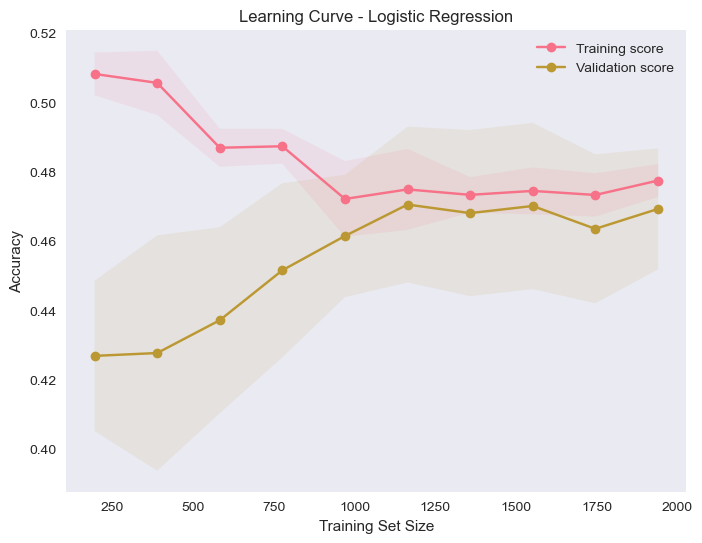


--- Classification Report ---
              precision    recall  f1-score   support

         Att       0.57      0.28      0.38       156
         Cen       0.40      0.49      0.44       212
         Dif       0.50      0.58      0.54       200
         Por       0.56      0.56      0.56        39

    accuracy                           0.47       607
   macro avg       0.51      0.48      0.48       607
weighted avg       0.49      0.47      0.47       607



<Figure size 800x600 with 0 Axes>

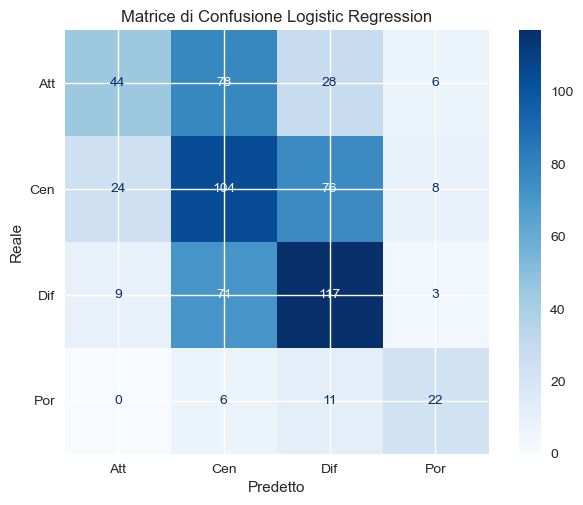

In [8]:
# ----------------- Logistic Regression --------------------

# Definizione della griglia degli iperparametri
param_grid = {
    'penalty':      ['l1', 'l2', 'elasticnet', 'none'],
    'C':            [0.01, 0.1, 1, 10, 100],
    'solver':       ['saga', 'lbfgs'],
    'class_weight': [None, 'balanced'],
    'l1_ratio':     [0, 0.5, 1]  # rilevante solo se penalty='elasticnet'
}

# Configurazione GridSearchCV
lr = LogisticRegression(random_state=42)
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione della ricerca sugli iper-parametri
grid.fit(X_trainS, y_trainS)

# Stampa dei risultati per ogni combinazione
results = grid.cv_results_
for mean_score, std_score, params in zip(
        results['mean_test_score'],
        results['std_test_score'],
        results['params']):
    print(f"{params} -> Mean CV Accuracy: {mean_score:.4f} (±{std_score:.4f})")

# Iperparametri ottimali
print("\nBest hyperparameters found:")
print(grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# Valutazione sul test set
y_pred = grid.predict(X_testS)
print("\nClassification report on test set:")
print(classification_report(y_testS, y_pred, digits=4))


model = LogisticRegression(
    C=100,
    class_weight=None,
    l1_ratio=0,           # Non è usato con penalty='l2' e solver='lbfgs', ma lo mettiamo per completezza
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model_regression = grid.best_estimator_

accuracy_lr = grid.best_estimator_.score(X_testS, y_testS)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_trainS, y=y_trainS,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

# Validation
y_pred = model_regression.predict(X_testS)

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_testS, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_testS, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Logistic Regression")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

Fitting 5 folds for each of 135 candidates, totalling 675 fits
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2} -> Mean CV Accuracy: 0.3737 (±0.0242)
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5} -> Mean CV Accuracy: 0.3824 (±0.0195)
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10} -> Mean CV Accuracy: 0.4021 (±0.0200)
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2} -> Mean CV Accuracy: 0.3762 (±0.0139)
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5} -> Mean CV Accuracy: 0.3840 (±0.0178)
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10} -> Mean CV Accuracy: 0.4141 (±0.0138)
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2} -> Mean CV Accuracy: 0.4133 (±0.0307)
{'max_depth': None, 'max_features': None, 'min

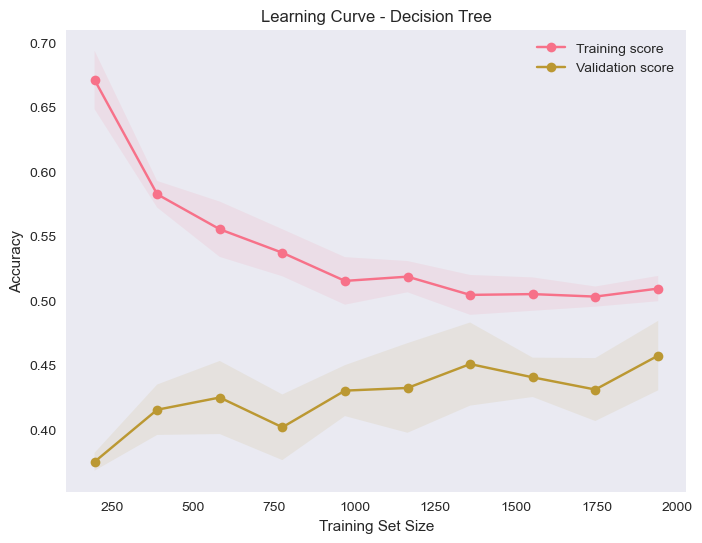


--- Classification Report ---
              precision    recall  f1-score   support

         Att       0.43      0.26      0.32       156
         Cen       0.35      0.35      0.35       212
         Dif       0.31      0.16      0.21       200
         Por       0.12      0.59      0.19        39

    accuracy                           0.28       607
   macro avg       0.30      0.34      0.27       607
weighted avg       0.34      0.28      0.29       607



<Figure size 800x600 with 0 Axes>

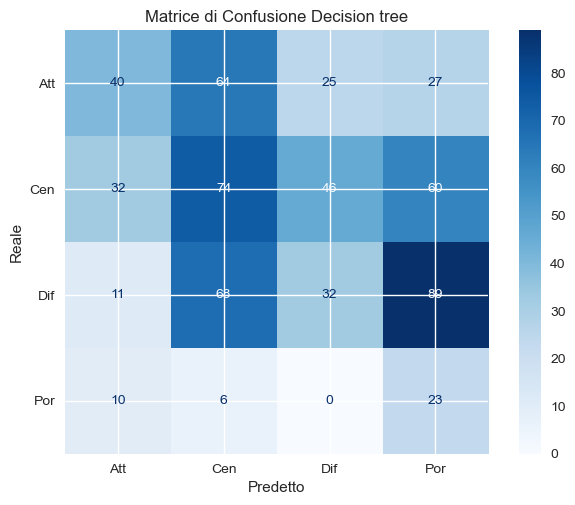

In [9]:
# ------------------------------------------Decision Tree-------------------------------------------

# Definizione della griglia degli iperparametri
param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

# 2) Configurazione GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione della ricerca sugli iper-parametri
grid_dt.fit(X_train, y_train)

# Stampa dei risultati per ogni combinazione
results_dt = grid_dt.cv_results_
for mean_score, std_score, params in zip(
        results_dt['mean_test_score'],
        results_dt['std_test_score'],
        results_dt['params']):
    print(f"{params} -> Mean CV Accuracy: {mean_score:.4f} (±{std_score:.4f})")

# Iperparametri ottimali
print("\nBest hyperparameters found for Decision Tree:")
print(grid_dt.best_params_)
print(f"Best CV Accuracy: {grid_dt.best_score_:.4f}")

# Valutazione sul test set
y_pred_dt = grid_dt.predict(X_test)
print("\nClassification report on test set (Decision Tree):")
print(classification_report(y_test, y_pred_dt, digits=4))

model = DecisionTreeClassifier(
    max_depth=5,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2
)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_train, y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.title('Learning Curve - Decision Tree')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

model_tree = grid_dt.best_estimator_

accuracy_dt = grid_dt.best_estimator_.score(X_test, y_test)

# Validation
y_pred = model_regression.predict(X_test)

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Decision tree")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'var_smoothing': 1e-09} -> Mean CV Accuracy: 0.3024 (±0.0221)
{'var_smoothing': 1e-08} -> Mean CV Accuracy: 0.3065 (±0.0196)
{'var_smoothing': 1e-07} -> Mean CV Accuracy: 0.3119 (±0.0183)
{'var_smoothing': 1e-06} -> Mean CV Accuracy: 0.3148 (±0.0174)
{'var_smoothing': 1e-05} -> Mean CV Accuracy: 0.3210 (±0.0187)
{'var_smoothing': 0.0001} -> Mean CV Accuracy: 0.3251 (±0.0177)
{'var_smoothing': 0.001} -> Mean CV Accuracy: 0.3325 (±0.0193)
{'var_smoothing': 0.01} -> Mean CV Accuracy: 0.3436 (±0.0145)
{'var_smoothing': 0.1} -> Mean CV Accuracy: 0.3391 (±0.0123)

Best hyperparameters found for GaussianNB:
{'var_smoothing': 0.01}
Best CV Accuracy: 0.3436

Classification report on test set (GaussianNB):
              precision    recall  f1-score   support

         Att     0.5625    0.2308    0.3273       156
         Cen     0.4400    0.1557    0.2300       212
         Dif     0.4318    0.4750    0.4524       200
         Por    

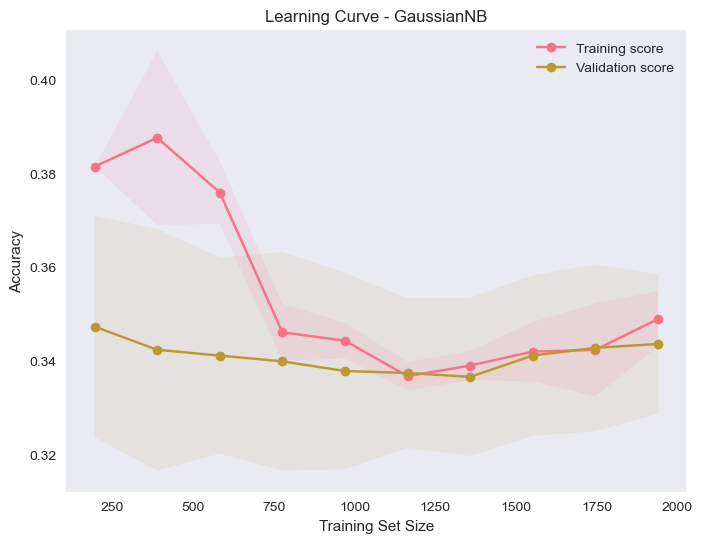


--- Classification Report ---
              precision    recall  f1-score   support

         Att       0.56      0.23      0.33       156
         Cen       0.44      0.16      0.23       212
         Dif       0.43      0.47      0.45       200
         Por       0.15      0.95      0.26        39

    accuracy                           0.33       607
   macro avg       0.40      0.45      0.32       607
weighted avg       0.45      0.33      0.33       607



<Figure size 800x600 with 0 Axes>

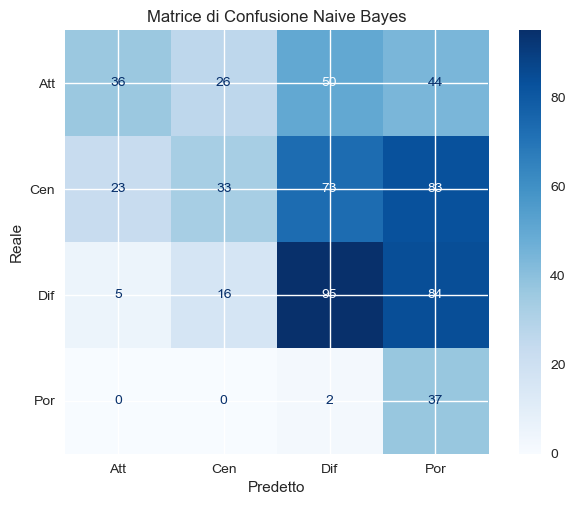

In [10]:
# ----------------------------Gaussian Naive Bayes---------------------------------

# Definizione della griglia degli iperparametri
param_grid_nb = {
    'var_smoothing': np.logspace(-9, -1, 9)
}

# Configurazione GridSearchCV
gnb = GaussianNB()
grid_nb = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esecuzione della ricerca sugli iperparametri
grid_nb.fit(X_trainS, y_trainS)

# Stampa dei risultati per ogni combinazione
results_nb = grid_nb.cv_results_
for mean_score, std_score, params in zip(
        results_nb['mean_test_score'],
        results_nb['std_test_score'],
        results_nb['params']):
    print(f"{params} -> Mean CV Accuracy: {mean_score:.4f} (±{std_score:.4f})")

# Iperparametri ottimali
print("\nBest hyperparameters found for GaussianNB:")
print(grid_nb.best_params_)
print(f"Best CV Accuracy: {grid_nb.best_score_:.4f}")

# Valutazione sul test set
y_pred_nb = grid_nb.predict(X_testS)
print("\nClassification report on test set (GaussianNB):")
print(classification_report(y_testS, y_pred_nb, digits=4))



# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=grid_nb.best_estimator_,
    X=X_trainS, y=y_trainS,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.title('Learning Curve - GaussianNB')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

model_Bayes = grid_nb.best_estimator_

accuracy_NB = grid_nb.best_estimator_.score(X_testS, y_testS)

# Validation
y_pred = model_Bayes.predict(X_testS)

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_testS, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_testS, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Naive Bayes")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

**Barplot delle accuracy dei modelli**

Viene creato un dizionario che raccoglie le accuracy finali ottenute dai diversi modelli di classificazione testati: Random Forest, Logistic Regression, Decision Tree e Gaussian Naive Bayes. Questo approccio consente di centralizzare le metriche chiave per un confronto immediato e ordinato tra le performance dei vari algoritmi, facilitando la valutazione di ciascun modello sullo stesso dataset.
Viene poi graficato un Barplot per visualizzare graficamente le accuracy dei modelli, rendendo immediato il confronto tra le prestazioni delle diverse tecniche di classificazione.
Infine si stampano i valori numerici della accuracy di ciascun modello, offrendo un riferimento preciso e quantitativo insieme alla rappresentazione visiva.

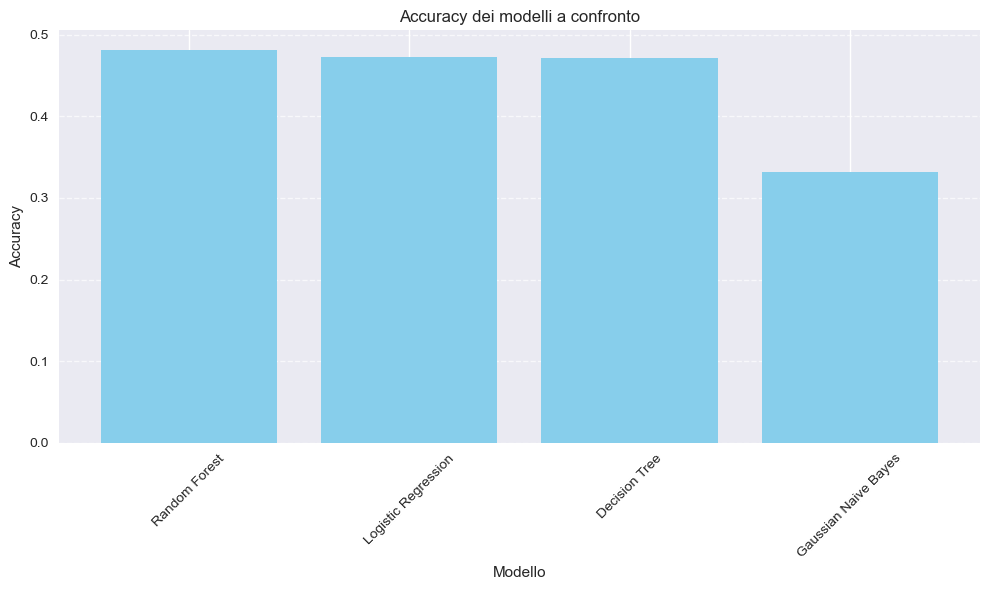

Random Forest: 0.48105436573311366 
Logistic Regression: 0.4728171334431631 
Decision Tree: 0.471169686985173 
Gaussian Naive Bayes: 0.3311367380560132


In [11]:
accuracies = {
    'Random Forest': accuracy_rf,
    'Logistic Regression': accuracy_lr,
    'Decision Tree': accuracy_dt,
    'Gaussian Naive Bayes': accuracy_NB
}

# Plot delle accuracy dei modelli per confronto
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Modello')
plt.title('Accuracy dei modelli a confronto')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print('Random Forest:', accuracy_rf, '\nLogistic Regression:', accuracy_lr, '\nDecision Tree:', accuracy_dt, '\nGaussian Naive Bayes:', accuracy_NB)

**Test del Random Forest (modello migliore) su "real_settings.csv"**


Per prima cosa, vengono effettuati il caricamento e la pulizia del nuovo dataset, utilizzando la funzione di preprocessing già definita. Questo step ha l'obiettivo di garantire che i dati siano coerenti e pronti per la valutazione del modello addestrato in precedenza.
Poi viene effettuata la separazione delle feature e della variabile target, per applicare correttamente il modello di classificazione e valutare le sue performance.
Dopo di che, i dati vengono trasformati con lo stesso scaler del training per ottenere coerenza tra i dati di training e quelli di test, evitando distorsioni dovute a scale differenti tra i dataset.
Quindi, viene applicato il modello Random Forest ottimizzato per predire i ruoli dei calciatori nel nuovo dataset. Il classification_report fornisce una valutazione dettagliata delle performance del modello, includendo metriche come accuracy, precision, recall ed f1-score per ciascuna classe, al fine di verificare la capacità di generalizzazione del modello su dati nuovi.
Infine, viene visualizzata la matrice di confusione che mostra come il modello ha classificato ciascun ruolo, evidenziando eventuali errori sistematici o confusione tra classi simili.

In [12]:
# Caricamento e pulizia del nuovo dataset "real_settings.csv"
real_settings_clean = clean_training_dataset('real_settings.csv', output_path='real_settings_clean.csv')

# Separazione feature/target per il test
X_real = real_settings_clean.drop(['Calciatore', 'Ruolo?', 'Stagione', 'Squadra'], axis=1)
y_real = real_settings_clean['Ruolo?']

# Trasformazione dei dati con lo stesso scaler usato durante il training
X_real_scaled = scaler.transform(X_real)

# Predizioni e valutazione con Random Forest
y_pred_real_rf = model_forest.predict(X_real_scaled)

print("Valutazione del Random Forest su real_settings_clean.csv:\n")
print(classification_report(y_real, y_pred_real_rf))

# Visualizzazione matrice di confusione
cm_rf_real = confusion_matrix(y_real, y_pred_real_rf)
disp_rf_real = ConfusionMatrixDisplay(confusion_matrix=cm_rf_real, display_labels=model_forest.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest su real_settings_clean.csv")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'real_settings.csv'